Image Deconvolution (ADMM w/ Total Variation and Circulant Blur)
=============================================

This example demonstrates the use of class [admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve an image deconvolution problem with isotropic total variation (TV) regularization.

  $$\mathrm{argmin}_{\mathbf{x}} \; \| \mathbf{y} - A \mathbf{x} \|_2^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is Toeplitz matrix, $\mathbf{y}$ is the blurred image, $C$ is a 2D Finite Difference operator, and $\mathbf{x}$ is the desired image.

In [1]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, CircularConvolveSolver
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
x_gt = snp.pad(discrete_phantom(phantom, 240), 8)
x_gt = jax.device_put(x_gt)  # Convert to jax type, push to GPU

Set up the forward operator and create a test signal consisting of a blurred signal with additive Gaussian noise.

In [3]:
n = 5  # Convolution kernel size
σ = 20.0 / 255  # Noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.CircularConvolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # Blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

Set up an ADMM solver object.

In [4]:
λ = 2e-2  # L1 norm regularization parameter
ρ = 5e-1  # ADMM penalty parameter
maxiter = 50  # Number of ADMM iterations

f = loss.SquaredL2Loss(y=y, A=A)
# Penalty parameters must be accounted for in the gi functions, not as additional inputs
g = λ * functional.L21Norm()  # Regularization functionals gi
C = linop.ConvolutionalGradient(x_gt.shape)
solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.adj(y),
    maxiter=maxiter,
    subproblem_solver=CircularConvolveSolver(),
    verbose=True,
)

Run the solver.

In [5]:
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Iter  Objective  Primal Rsdl  Dual Rsdl
---------------------------------------
   0  2.706e+02    8.268e+00  6.987e+00
   1  2.895e+02    2.570e+00  4.973e+00
   2  2.839e+02    1.740e+00  3.645e+00
   3  2.821e+02    1.262e+00  3.226e+00
   4  2.809e+02    9.685e-01  2.882e+00
   5  2.800e+02    7.983e-01  2.574e+00
   6  2.792e+02    6.756e-01  2.322e+00
   7  2.786e+02    5.836e-01  2.112e+00
   8  2.780e+02    5.138e-01  1.933e+00
   9  2.776e+02    4.499e-01  1.788e+00
  10  2.772e+02    3.960e-01  1.666e+00
  11  2.769e+02    3.565e-01  1.558e+00
  12  2.767e+02    3.205e-01  1.465e+00
  13  2.764e+02    2.950e-01  1.378e+00
  14  2.762e+02    2.697e-01  1.304e+00
  15  2.760e+02    2.451e-01  1.238e+00
  16  2.758e+02    2.229e-01  1.180e+00
  17  2.757e+02    2.035e-01  1.127e+00
  18  2.755e+02    1.888e-01  1.078e+00
  19  2.754e+02    1.778e-01  1.032e+00
  20  2.753e+02    1.655e-01  9.903e-01
  21  2.752e+02    1.529e-01  9.534e-01
  22  2.751e+02    1.444e-01  9.166e-01


  32  2.744e+02    8.876e-02  6.493e-01
  33  2.743e+02    8.569e-02  6.288e-01
  34  2.743e+02    8.376e-02  6.083e-01
  35  2.743e+02    8.053e-02  5.894e-01
  36  2.742e+02    7.725e-02  5.716e-01
  37  2.742e+02    7.365e-02  5.549e-01
  38  2.741e+02    7.091e-02  5.390e-01
  39  2.741e+02    6.752e-02  5.240e-01
  40  2.741e+02    6.537e-02  5.090e-01
  41  2.741e+02    6.383e-02  4.943e-01
  42  2.740e+02    6.187e-02  4.806e-01
  43  2.740e+02    5.966e-02  4.676e-01
  44  2.740e+02    5.761e-02  4.551e-01
  45  2.740e+02    5.554e-02  4.430e-01
  46  2.739e+02    5.405e-02  4.311e-01
  47  2.739e+02    5.292e-02  4.196e-01
  48  2.739e+02    5.131e-02  4.089e-01
  49  2.739e+02    4.934e-02  3.988e-01


Show the recovered image.

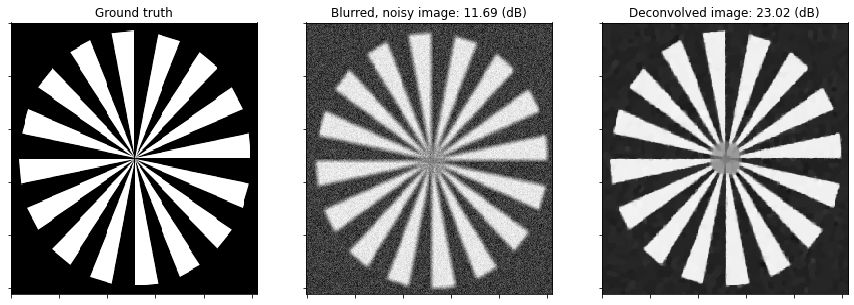

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, y), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

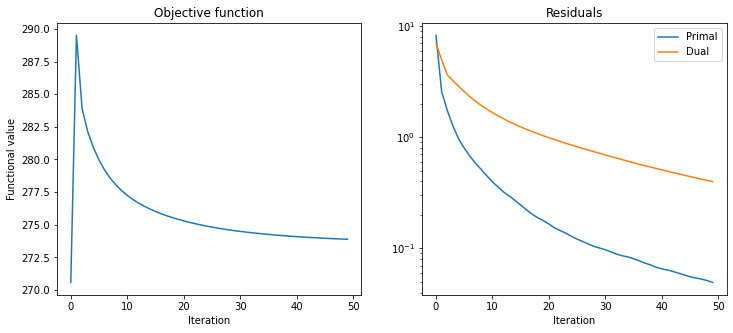

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Primal_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()